# Full vehicle model

In [ ]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


## Drive cycle import

In [ ]:
df_drivecycle = pd.read_excel(r'drive_cycles\drive_cycle_itr4.xlsx', sheet_name = 'itr4_avg')

In [ ]:
df_drivecycle.columns

## Parameters

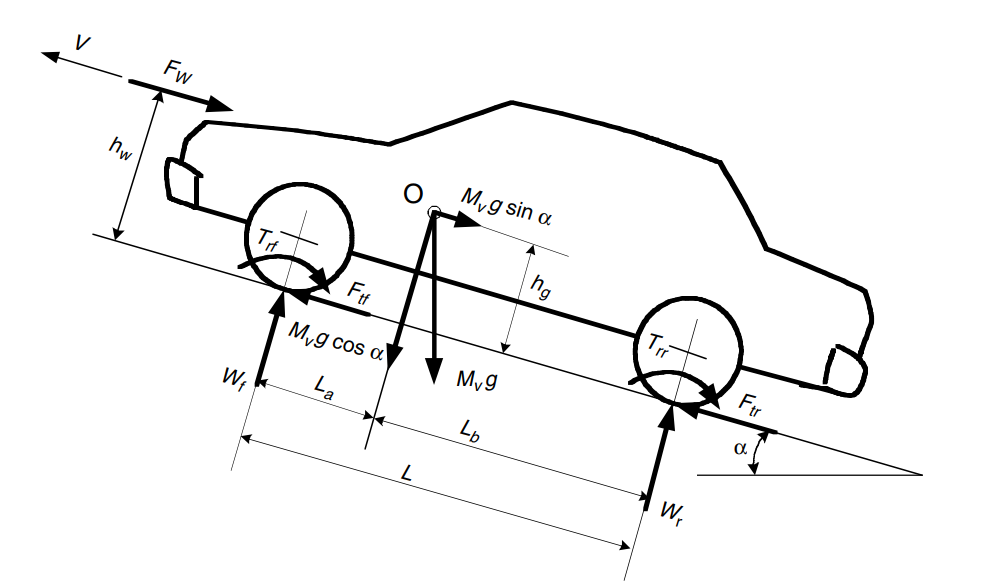

In [ ]:
plt.plot(df_drivecycle['time_s'], df_drivecycle['avg_speed_kmph'])
plt.grid()

### vehicle parameters (select - 0)

In [ ]:
vehicle_param = {'mass': 300, #kg
                 'g' : 9.81, #m/s^2 
                 'c_rr': 0.017,
                 'c_d': 0.9,
                 'f_area': 0.42, #m^2
                 'rho': 1.2, #kg/m^3
                 'gradient': 0, #deg
                 'v_air': 0, #tail wind in vehicle direction kmph
                 'wb' : 1.340, #m
                 'x_cg': .713, #m
                 'z_cg': .633, #m
                 'w_r' : 0.3, #m (average radius of front and rear wheel)
                 'i_whl' : 0.42, #kgm2 rolling inertia of wheel
                 'Eff_chain': 0.99,
                 'R_whl_gb': 3.294, # reduction ratio between gearbox and wheel
                 'i_gb' : 0.002, #kgm2
                 'Eff_gb' : 0.99,
                 'R_gb_mtr' : 1.676, # reduction ratio between gearbox and motor
                 'i_mtr' : 0.004 #kgm2
                 }


### coastdown parameters (select - 1)

In [ ]:
coastdown_param = {'mass': 300, #kg
                    'A' :36.82, #N
                #    'B' :0, #N/kmph
                   'C' :0.0294 #N/kmph^2
                   }

## Vehicle Force model

### Force Model

In [ ]:
veh0_coast1 = 1

In [ ]:
if veh0_coast1 == 0:
    # Fr = (0.01*(1+df_drivecycle['avg_speed_kmph'].to_numpy()/(3.6*100)))*vehicle_param['mass']*vehicle_param['g']*math.cos(math.radians(vehicle_param['gradient'])) #for speed under 128kmph
    Fr = vehicle_param['c_rr']*vehicle_param['mass']*vehicle_param['g']*math.cos(math.radians(vehicle_param['gradient']))
    Far = (0.5*vehicle_param['rho']*vehicle_param['f_area']*vehicle_param['c_d']/3.6**2)*(df_drivecycle['avg_speed_kmph'].to_numpy()+vehicle_param['v_air'])**2
    Fgr = vehicle_param['c_rr']*vehicle_param['mass']*vehicle_param['g']*math.sin(math.radians(vehicle_param['gradient']))
    Fac = vehicle_param['mass']*df_drivecycle['avg_accn_mps2'].to_numpy()
    Fr = Fr+Far+Fgr+Fac
    print('F_calc')
else:
    Fr = coastdown_param['A']
    Far = coastdown_param['C']*df_drivecycle['avg_speed_kmph']**2
    Fac = coastdown_param['mass']*df_drivecycle['avg_accn_mps2']
    Fr = Fr + Far + Fac
    print('F_coast')

In [ ]:
max(Fr)

### Roational resistance model

#### wheel

In [ ]:
Tr = Fr*vehicle_param['w_r'] #Nm

In [ ]:
Td_whl = Tr
# drive_Td_whl = np.clip(Tr, a_min = 0, a_max = None)
alpha_whl = df_drivecycle['avg_accn_mps2'].to_numpy()/vehicle_param['w_r']
torque_whl = alpha_whl * vehicle_param['i_whl']
itorque_whl = Td_whl + torque_whl
rpm_whl = ((df_drivecycle['avg_speed_kmph'].to_numpy()/3.6)/(2*math.pi*vehicle_param['w_r']))*60

#### gearbox

In [ ]:
T_gb = itorque_whl/(vehicle_param['R_whl_gb']*vehicle_param['Eff_chain'])
alpha_gb = alpha_whl * vehicle_param['R_whl_gb']
torque_gb = alpha_gb * vehicle_param['i_gb']
itorque_gb = T_gb + torque_gb
rpm_gb = rpm_whl * vehicle_param['R_whl_gb']

#### motor

In [ ]:
T_mtr = itorque_gb/(vehicle_param['R_gb_mtr']*vehicle_param['Eff_gb'])
alpha_mtr = alpha_gb * vehicle_param['R_gb_mtr']
torque_mtr = alpha_mtr * vehicle_param['i_mtr']
itorque_mtr = T_mtr + torque_mtr
rpm_mtr = rpm_gb * vehicle_param['R_gb_mtr']

#### drive forces

In [ ]:
drive_itorque_whl = np.clip(itorque_whl, a_min = 0, a_max = None)
drive_itorque_gb= np.clip(itorque_gb, a_min = 0, a_max = None)
drive_itorque_mtr = np.clip(itorque_mtr, a_min = 0, a_max = None)

#### braking forces

In [ ]:
brake_itorque_whl = np.clip(itorque_whl, a_min = None, a_max = 0)
# brake_itorque_whl = brake_itorque_whl[brake_itorque_whl != 0] 

brake_itorque_gb= np.clip(itorque_gb, a_min = None, a_max = 0)
# brake_itorque_gb = brake_itorque_gb[brake_itorque_gb != 0] 

brake_itorque_mtr = np.clip(itorque_mtr, a_min = None, a_max = 0)
# brake_itorque_mtr = brake_itorque_mtr[brake_itorque_mtr != 0] 

## Motor and Controller

### old efficiency

In [ ]:
mtr_eff_map = pd.read_csv(r"mtr_eff.csv", index_col = [0])
mtr_eff_arr = mtr_eff_map.values

In [ ]:
mtr_eff_dc = []
for actual_torque, actual_rpm in zip(drive_itorque_mtr, rpm_mtr):
    mtr_eff_dc.append(mtr_eff_arr[int(actual_rpm//100),int(actual_torque/10)])

mtr_eff_dc = np.array(mtr_eff_dc)

In [ ]:
mtr_ctrl_eff_map = pd.read_csv(r"mtr_ctrl_eff.csv", index_col = [0])
mtr_ctrl_eff_arr = mtr_ctrl_eff_map.values

In [ ]:
mtr_ctrl_eff_dc = []
for actual_torque, actual_rpm in zip(drive_itorque_mtr, rpm_mtr):
    mtr_ctrl_eff_dc.append(mtr_ctrl_eff_arr[int(actual_rpm//100),int(actual_torque/10)])

mtr_ctrl_eff_dc = np.array(mtr_ctrl_eff_dc)

In [ ]:
total_mtr_system_eff_dc = mtr_ctrl_eff_dc * mtr_eff_dc/10000
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(total_mtr_system_eff_dc*100)
plt.ylabel("Efficiency %")

In [ ]:

fig1 = go.Figure(data=[go.Surface(z=mtr_eff_arr)])
fig1.update_layout(title='Motor Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig1.show()

In [ ]:
fig2 = go.Figure(data=[go.Surface(z=mtr_ctrl_eff_arr)])

fig2.update_layout(title='Motor Controller Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig2.show()

In [ ]:
fig5 = go.Figure(data=[go.Surface(z=((mtr_ctrl_eff_arr*mtr_eff_arr).transpose()))])

fig5.update_layout(title='Total Motor Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig5.show()

In [ ]:
total_itorque_mtr = brake_itorque_mtr + drive_itorque_mtr
# plt.plot(total_itorque_mtr)
df_total_itorque_mtr  = pd.DataFrame()
df_total_itorque_mtr["drive_itorque_mtr"]= drive_itorque_mtr
df_total_itorque_mtr["total_itorque_mtr"] = total_itorque_mtr
df_total_itorque_mtr["rpm_mtr"] = rpm_mtr
df_total_itorque_mtr["total_mtr_system_eff_dc"] =   total_mtr_system_eff_dc
df_total_itorque_mtr["speed_kmph"] = df_drivecycle["speed_kmph"]
df_total_itorque_mtr["time_s"] = df_drivecycle["time_s"]

# temp = df_total_itorque_mtr["total_mtr_system_eff_dc"]
df_total_itorque_mtr.loc[df_total_itorque_mtr["total_itorque_mtr"]<0,'total_mtr_system_eff_dc'] = np.nan


In [ ]:
fig3 = sns.lineplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph",linewidth = 0.7, color = "black")
fig3 = sns.scatterplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph", hue="total_mtr_system_eff_dc",  palette = "rocket_r", linewidth = 0 )
sns.move_legend(fig3, "upper left", bbox_to_anchor=(1, 1))


In [ ]:
total_mtr_eff_arr = mtr_eff_arr* mtr_ctrl_eff_arr/10000
total_mtr_eff_arr= (total_mtr_eff_arr.transpose())[::-1]


In [ ]:
rpm = np.arange(0, 7100, 100)
torque = np.arange(0, 100, 10)

[X, Y] = np.meshgrid(rpm, torque)  
Z = total_mtr_eff_arr

fig, ax = plt.subplots(1, 1)
cs = ax.contourf(X, Y, Z)
cbar = fig.colorbar(cs)
ax = sns.scatterplot(data=df_total_itorque_mtr, x="rpm_mtr", y="drive_itorque_mtr", color = "blue", linewidth = 1, marker= "x")
ax.set_xlabel("RPM")
ax.set_ylabel("Torque")
# ax.legend().set_visible(False)
# ax.set_xlim(0,max(df_total_itorque_mtr["rpm_mtr"])+100)
# ax.set_ylim(0,max(df_total_itorque_mtr["drive_itorque_mtr"])+5)
fig.show()

### sevcon eff

In [84]:
sevcon_eff_map = pd.read_csv(r"sevcon_eff.csv", index_col = [0])
sevcon_eff_arr = sevcon_eff_map.values
# sevcon_eff_arr[np.isnan(sevcon_eff_arr)] = 0

In [85]:
fig5 = go.Figure(data=[go.Surface(z=((sevcon_eff_arr).transpose()))])

fig5.update_layout(title='SEVCON Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig5.show()

In [86]:
sevcon_eff_dc = []
for actual_torque, actual_rpm in zip(drive_itorque_mtr, rpm_mtr):
    sevcon_eff_dc.append(sevcon_eff_arr[int(actual_rpm//500),int(actual_torque/10)])

sevcon_eff_dc = np.array(sevcon_eff_dc)

In [87]:
def apply_eff_map(actual_torque, actual_rpm, sevcon_eff_arr, rpm_bin_edges, torque_bin_edges):
    # Use numpy's searchsorted function to find the index of the bin edge for actual_rpm
    rpm_bin_indices = np.searchsorted(rpm_bin_edges, actual_rpm) - 1
    
    # Use numpy's searchsorted function to find the index of the bin edge for actual_torque
    torque_bin_indices = np.searchsorted(torque_bin_edges, actual_torque) - 1
    
    # Clip indices to ensure they are within valid range
    rpm_bin_indices = np.clip(rpm_bin_indices, 0, len(rpm_bin_edges) - 2)
    torque_bin_indices = np.clip(torque_bin_indices, 0, len(torque_bin_edges) - 2)

    # Create an array to store the binned values
    sevcon_eff_dc = sevcon_eff_arr[rpm_bin_indices, torque_bin_indices]

    return sevcon_eff_dc

In [88]:
sevcon_eff_dc = apply_eff_map(drive_itorque_mtr,
rpm_mtr,sevcon_eff_arr,
sevcon_eff_map.index.to_numpy().astype(int),
sevcon_eff_map.columns.to_numpy().astype(int))

In [89]:
total_mtr_system_eff_dc = sevcon_eff_dc/100

In [90]:
total_itorque_mtr = brake_itorque_mtr + drive_itorque_mtr
# plt.plot(total_itorque_mtr)
df_total_itorque_mtr  = pd.DataFrame()
df_total_itorque_mtr["drive_itorque_mtr"]= drive_itorque_mtr
df_total_itorque_mtr["total_itorque_mtr"] = total_itorque_mtr
df_total_itorque_mtr["rpm_mtr"] = rpm_mtr
df_total_itorque_mtr["total_mtr_system_eff_dc"] =   total_mtr_system_eff_dc
df_total_itorque_mtr["speed_kmph"] = df_drivecycle["speed_kmph"]
df_total_itorque_mtr["time_s"] = df_drivecycle["time_s"]

# temp = df_total_itorque_mtr["total_mtr_system_eff_dc"]
df_total_itorque_mtr.loc[df_total_itorque_mtr["total_itorque_mtr"]<0,'total_mtr_system_eff_dc'] = np.nan


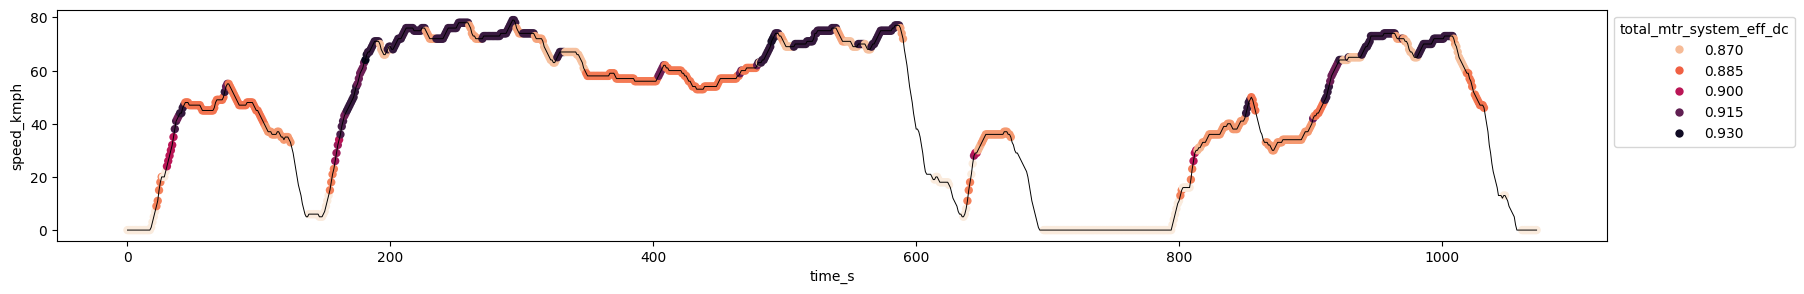

In [91]:
fig3 = sns.lineplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph",linewidth = 0.7, color = "black")
fig3 = sns.scatterplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph", hue="total_mtr_system_eff_dc",  palette = "rocket_r", linewidth = 0 )
sns.move_legend(fig3, "upper left", bbox_to_anchor=(1, 1))


In [92]:
total_mtr_eff_arr = sevcon_eff_arr/100
total_mtr_eff_arr= (total_mtr_eff_arr.transpose())

Text(0, 0.5, 'Torque')

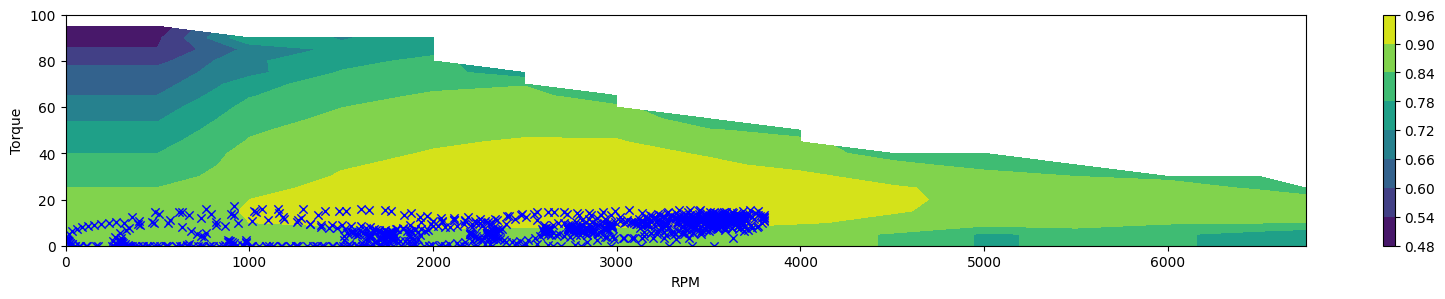

In [93]:
rpm = sevcon_eff_map.index.to_numpy().astype(int)
torque = sevcon_eff_map.columns.to_numpy().astype(int)

[X, Y] = np.meshgrid(rpm, torque)  
Z = total_mtr_eff_arr

fig, ax = plt.subplots(1, 1)
cs = ax.contourf(X, Y, Z)
cbar = fig.colorbar(cs)
ax = sns.scatterplot(data=df_total_itorque_mtr, x="rpm_mtr", y="drive_itorque_mtr", color = "blue", linewidth = 1, marker= "x")
ax.set_xlabel("RPM")
ax.set_ylabel("Torque")
# ax.legend().set_visible(False)
# ax.set_xlim(0,max(df_total_itorque_mtr["rpm_mtr"])+100)
# ax.set_ylim(0,max(df_total_itorque_mtr["drive_itorque_mtr"])+5)
# fig.show()

## Stats generation

In [ ]:
time = df_total_itorque_mtr['time_s']
speed = df_total_itorque_mtr['speed_kmph']
mtr_sys_eff = df_total_itorque_mtr['total_mtr_system_eff_dc']

In [ ]:
diff = [((speed[i+1]-speed[i-1])/3.6)/(time[i+1]-time[i-1]) for i in np.arange(1,len(time)-1)]
accn_mps2 = np.insert(diff,0,0)
accn_mps2 = np.append(accn_mps2,0)

### SAFD generation

In [ ]:
def safd_matrix(speed,accn_mps2,size):

    #bins
    bins_speed = np.round(np.arange(0,np.ceil(speed.max())+10,10).tolist(),2)
    bins_accn = np.round(np.arange(np.ceil(accn_mps2.min()*10)/10-0.1,np.ceil(accn_mps2.max()*10)/10+0.1,0.1).tolist(),2)

    speed_states = np.digitize(speed, bins_speed) - 1
    accn_states = np.digitize(accn_mps2, bins_accn) - 1

    df_states = pd.DataFrame()
    df_states['speed_states'] = speed_states
    df_states['accn_states'] = accn_states

    safd_matrix = np.zeros([len(bins_accn),len(bins_speed)])

    speed_lable = []
    for t in np.arange(len(bins_speed)-1):
        speed_lable.append(str(bins_speed[t])+'-'+str(bins_speed[t+1]))

    accn_lable = []
    for t in np.arange(len(bins_accn)-1):
        accn_lable.append(str(bins_accn[t])+'-'+str(bins_accn[t+1]))

    for i in range(len(bins_accn)):
        j = 0
        for j in range(len(bins_speed)):
            safd_matrix[i,j] = len(df_states[(df_states['speed_states'] == j)&(df_states['accn_states'] == i)])

    df_safd_matrix = pd.DataFrame(safd_matrix)
    df_safd_matrix.drop(df_safd_matrix.index[-1], inplace=True)
    df_safd_matrix.drop(df_safd_matrix.columns[-1], axis=1, inplace=True)

    fig,ax = plt.subplots(figsize=size)
    # heatmap = ax.imshow(df_safd_matrix.values, cmap = 'viridis',aspect='auto')
    heatmap = ax.imshow(df_safd_matrix.values, cmap = 'viridis',aspect='auto', vmax=500)
    ax.set_xticks(np.arange(len(speed_lable)))
    ax.set_yticks(np.arange(len(accn_lable)))
    ax.set_xticklabels(speed_lable)
    ax.set_yticklabels(accn_lable)
    for i in range(len(accn_lable)):
        for j in range(len(speed_lable)):
            text = ax.text(j, i, '{:.0f}'.format(safd_matrix[i, j]),
                        ha="center", va="center", color="w")

    cbar = plt.colorbar(heatmap)
    return df_safd_matrix

### power and energy

In [ ]:
import plotly.express as px

def energy_calc(time,speed,accn_mps2, mtr_sys_eff, coastdown_param):
    df_energy = pd.DataFrame()
    df_energy['time_s'] = time
    df_energy['speed_kmph'] = speed
    df_energy['accn_mps2'] = accn_mps2
    df_energy['dist_km'] = ((((df_energy['speed_kmph'].add(df_energy['speed_kmph'].shift(1)))/(2*3600))*(df_energy['time_s'] .sub(df_energy['time_s'] .shift(1)))).fillna(0)).cumsum()

    df_energy['Fr'] = coastdown_param['A'] + coastdown_param['C']*pow(df_energy['speed_kmph'],2) # a+cv^2 in N and v in kmph
    df_energy['Fa'] = coastdown_param['mass']*df_energy['accn_mps2'] # ma in N
    df_energy['Ft'] = df_energy['Fa'] + df_energy['Fr'] # total tractive effort in N

    # power
    df_energy['m_pwr_kW'] = (df_energy['Ft'] * df_energy['speed_kmph']/3.6)/1000 
    df_energy['e_pwr_kW'] = df_energy['m_pwr_kW'] / mtr_sys_eff

    # energy
    df_energy['m_energy_Wh'] = ((((df_energy['m_pwr_kW'].add(df_energy['m_pwr_kW'].shift(1)))*1000/(2*3600))*(df_energy['time_s'] .sub(df_energy['time_s'] .shift(1)))).fillna(0)).cumsum()
    df_energy['e_energy_Wh'] = ((((df_energy['e_pwr_kW'].add(df_energy['e_pwr_kW'].shift(1)))*1000/(2*3600))*(df_energy['time_s'] .sub(df_energy['time_s'] .shift(1)))).fillna(0)).cumsum()

    #Wh/km
    df_energy['m_Wh/km'] = ((df_energy['m_energy_Wh'])/df_energy['dist_km']).fillna(0)
    df_energy['e_Wh/km'] = ((df_energy['e_energy_Wh'])/df_energy['dist_km']).fillna(0)

    df_energy = df_energy.round(2)

    fig = px.line(df_energy,x = 'time_s',y = df_energy.columns)
    display(fig)
    return df_energy

In [ ]:
def stats(df_energy):
    stats = {}
    stats['total_time_s'] = df_energy['time_s'].max()
    stats['dist_km'] = df_energy['dist_km'].max()
    stats['max_speed_kmph'] = df_energy['speed_kmph'].max()
    stats['avg_speed_kmph'] = df_energy['speed_kmph'].mean().round(2)
    stats['max_positive_accn_mps2'] = df_energy['accn_mps2'].max()
    stats['max_negative_accn_mps2'] = df_energy['accn_mps2'].min()
    stats['rms_positive_accn_mps2'] = round(np.sqrt(np.mean(df_energy.loc[df_energy['accn_mps2']>0,'accn_mps2'] ** 2)),2)
    stats['rms_negative_accn_mps2'] = round(np.sqrt(np.mean(df_energy.loc[df_energy['accn_mps2']<0,'accn_mps2'] ** 2)),2)
    stats['avg_m_power_kW'] = df_energy['m_pwr_kW'].mean().round(2)
    stats['avg_e_power_kW'] = df_energy['e_pwr_kW'].mean().round(2)
    stats['max_m_power_kW'] = df_energy['m_pwr_kW'].max()
    stats['max_e_power_kW'] = df_energy['e_pwr_kW'].max()
    stats['total_m_energy_Wh'] = df_energy['m_energy_Wh'].iloc[-1]
    stats['total_e_energy_Wh'] = df_energy['e_energy_Wh'].iloc[-1]
    stats['m_Wh/km'] = df_energy['m_Wh/km'].iloc[-1]
    stats['e_Wh/km'] = df_energy['e_Wh/km'].iloc[-1]
    # stats['energy_eff'] = round(stats['total_m_energy_Wh']/stats['total_e_energy_Wh'] * 100,2)
    stats['wh/km_eff'] = round(stats['m_Wh/km']/stats['e_Wh/km'] * 100,2)
    return stats

In [ ]:
df_safd_matrix = safd_matrix(speed,accn_mps2,[30,30])

In [ ]:
df_energy = energy_calc(time,speed,accn_mps2,mtr_sys_eff,coastdown_param)

In [ ]:
dc_stats = stats(df_energy)
for key in dc_stats:
    print(key, ' : ', dc_stats[key])

## Range estimation